In [1]:
import numpy as np
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Rescaling, AveragePooling2D

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy

2025-06-01 08:44:07.434627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748767447.630148      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748767447.689053      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import matplotlib.pyplot as plt  # PIL doesn't work without importing matplotlib! (Wonderful Python!)
import PIL

In [4]:
tf.__version__

'2.18.0'

In [5]:
directory = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

In [6]:
for root, dirs, files in os.walk(directory):
    print('the root:', root)
    print('the directories in it:', dirs, end='\n\n')

the root: /kaggle/input/rice-image-dataset/Rice_Image_Dataset
the directories in it: ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

the root: /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag
the directories in it: []

the root: /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Basmati
the directories in it: []

the root: /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Jasmine
the directories in it: []

the root: /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Arborio
the directories in it: []

the root: /kaggle/input/rice-image-dataset/Rice_Image_Dataset/Ipsala
the directories in it: []



In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=directory,
    labels='inferred',
    label_mode='categorical',
#     class_names=['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
    color_mode='grayscale',
    batch_size=32,
    image_size=(100, 100),
    seed=0,
    validation_split=0.2,
    subset='training', 
)
train_ds

Found 75000 files belonging to 5 classes.
Using 60000 files for training.


I0000 00:00:1748767603.551640      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [8]:
test_ds = keras.utils.image_dataset_from_directory(
    directory=directory,
    labels='inferred',
    label_mode='categorical',
#     class_names=['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
    color_mode='grayscale',
    batch_size=32,
    image_size=(100, 100),
    seed=0,
    validation_split=0.2,
    subset='validation', 
)

Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


In [9]:
train_ds.class_names


['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

len(images): 32  images.shape: (32, 100, 100, 1)
len(labels): 32  labels.shape: (32, 5)


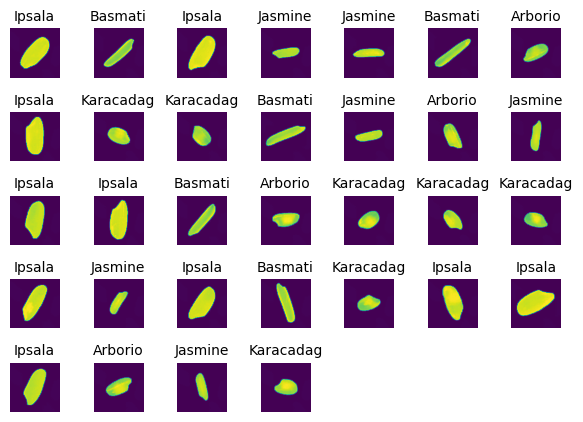

In [10]:
classes = train_ds.class_names

count = 0
plt.figure(figsize=(6, 6))    
for (images, labels) in train_ds.as_numpy_iterator():  # (images, labels) این دو تا باید حتماً توی پرانتز می‌بودن وگرنه حلقه تموم نمیشد
    if count > 0:
        break
    
    print('len(images):', len(images), ' images.shape:', images.shape)
    print('len(labels):', len(labels), ' labels.shape:', labels.shape)
    
    for i in range(len(images)):
        index_of_label = np.nonzero(labels[i])  # output: an integer number
        plt.subplot(7, 7, i+1)
        plt.imshow(images[i])
        plt.title(classes[index_of_label[0][0]], fontsize=10)
        plt.axis("off")
        
    count += 1

plt.tight_layout()
# plt.show()

In [11]:
model = Sequential()
model.add(Input(shape=(100, 100, 1)))
model.add(Rescaling(scale=1/255))  #output scale between [0, 1]. If scale=1/127.5 -> output scale between [-1, 1]
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=5, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 100, 100, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 50, 50, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,685 (326.89 KB)

 Trainable params: 83,685 (326.89 KB)

 Non-trainable params: 0 (0.00 B)

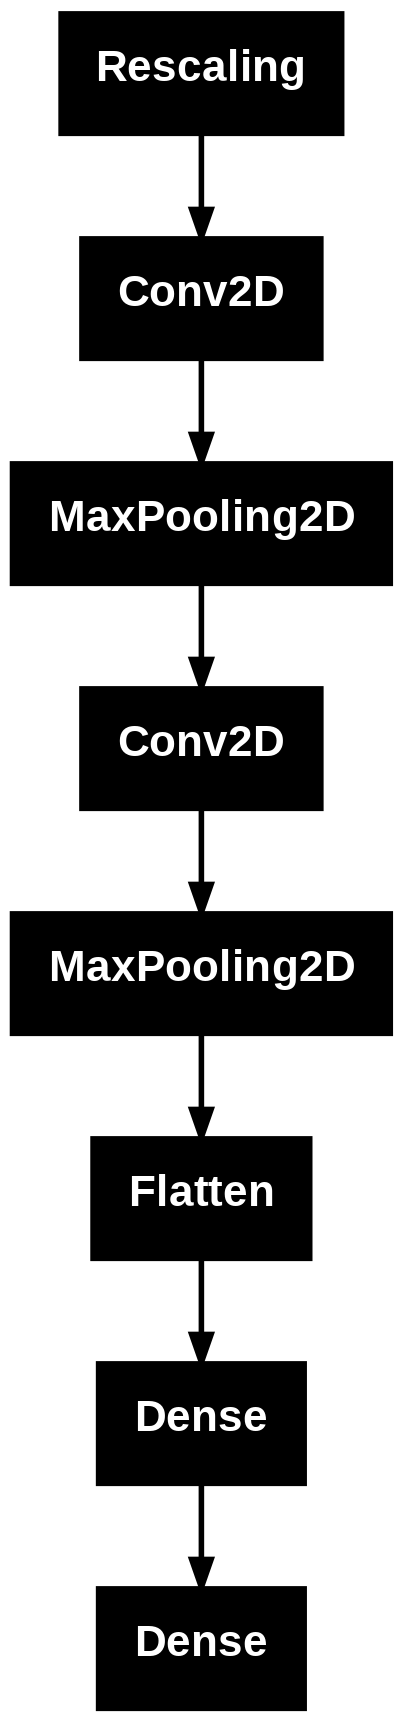

In [13]:
# import pydot
# import graphviz
tf.keras.utils.plot_model(model)

In [14]:
loss = CategoricalCrossentropy()
opt = Adam()
metric = CategoricalAccuracy()

In [15]:
model.compile(loss=loss, optimizer=opt, metrics=[metric])

In [16]:
train, validation = tf.keras.utils.split_dataset(train_ds, left_size=0.8)
type(train)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [17]:
history_epoch_32 = model.fit(train, validation_data=validation,
#                     classes, 
                    epochs=10, 
                    # batch_size=32, 
                   )

Epoch 1/10


I0000 00:00:1748767723.431844      63 service.cc:148] XLA service 0x7e8f44009910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748767723.432531      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748767723.672361      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


  54/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.4320 - loss: 1.3073

I0000 00:00:1748767725.357430      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - categorical_accuracy: 0.8750 - loss: 0.3299 - val_categorical_accuracy: 0.9668 - val_loss: 0.0954
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9684 - loss: 0.0937 - val_categorical_accuracy: 0.9746 - val_loss: 0.0756
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9733 - loss: 0.0799 - val_categorical_accuracy: 0.9760 - val_loss: 0.0699
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9753 - loss: 0.0701 - val_categorical_accuracy: 0.9788 - val_loss: 0.0647
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9777 - loss: 0.0627 - val_categorical_accuracy: 0.9787 - val_loss: 0.0629
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9792 - loss: 0.0567 - val_categorical_accuracy: 0.9799 - val_loss: 0.0607
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9820 -

In [18]:
history_epoch_50 = model.fit(train, validation_data=validation,
#                     classes, 
                    epochs=10, 
                    batch_size=50, 
                   )

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9885 - loss: 0.0350 - val_categorical_accuracy: 0.9780 - val_loss: 0.0683
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9897 - loss: 0.0319 - val_categorical_accuracy: 0.9785 - val_loss: 0.0661
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9900 - loss: 0.0300 - val_categorical_accuracy: 0.9768 - val_loss: 0.0696
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - categorical_accuracy: 0.9905 - loss: 0.0283 - val_categorical_accuracy: 0.9808 - val_loss: 0.0573
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9925 - loss: 0.0236 - val_categorical_accuracy: 0.9779 - val_loss: 0.0715
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9922 - loss: 0.0228 - val_categorical_accuracy: 0.9813 - val_loss: 0.0655
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy

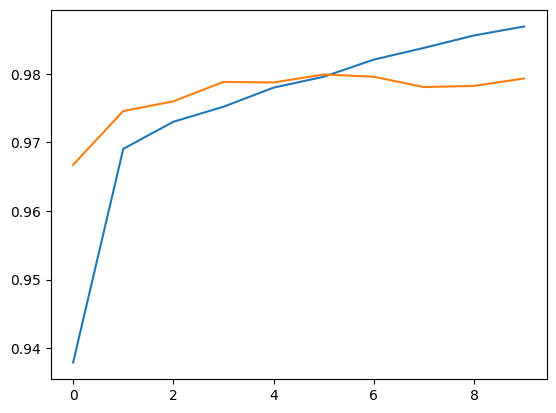

In [19]:
plt.plot(history_epoch_32.history['categorical_accuracy'])
plt.plot(history_epoch_32.history['val_categorical_accuracy'])

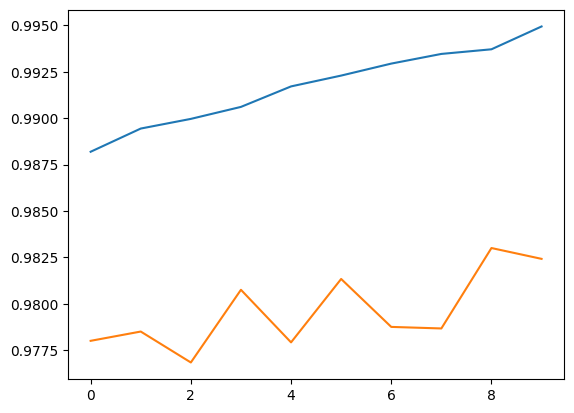

In [20]:
plt.plot(history_epoch_50.history['categorical_accuracy'])
plt.plot(history_epoch_50.history['val_categorical_accuracy'])